In [3]:
import pickle
import os

In [1]:
import pickle
import os

# Define WESAD dataset path
dataset_path = r"D:\COAI_paper\WESAD\WESAD"

# 
subject_id = "S2"

# Path to the .pkl file
subject_file = os.path.join(dataset_path, subject_id, f"{subject_id}.pkl")

# Check if the file exists
if os.path.exists(subject_file):
    print(f"Found file: {subject_file}")
else:
    print(f"File not found: {subject_file}")

# Load the pickle file with correct encoding
with open(subject_file, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

# Print keys to understand structure
print("\nKeys in the loaded data:")
print(data.keys())


# Explore inside chest and wrist
print("\nChest signal keys:", data['signal']['chest'].keys())
print("Wrist signal keys:", data['signal']['wrist'].keys())

# Now check shapes for specific signals
print("\nChest ECG shape:", data['signal']['chest']['ECG'].shape)
print("Chest EDA shape:", data['signal']['chest']['EDA'].shape)
print("Chest Respiration shape:", data['signal']['chest']['Resp'].shape)

# And some labels
print("\nFirst 20 labels:")
print(data['label'][:20])



Found file: D:\COAI_paper\WESAD\WESAD\S2\S2.pkl

Keys in the loaded data:
dict_keys(['signal', 'label', 'subject'])

Chest signal keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
Wrist signal keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

Chest ECG shape: (4255300, 1)
Chest EDA shape: (4255300, 1)
Chest Respiration shape: (4255300, 1)

First 20 labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


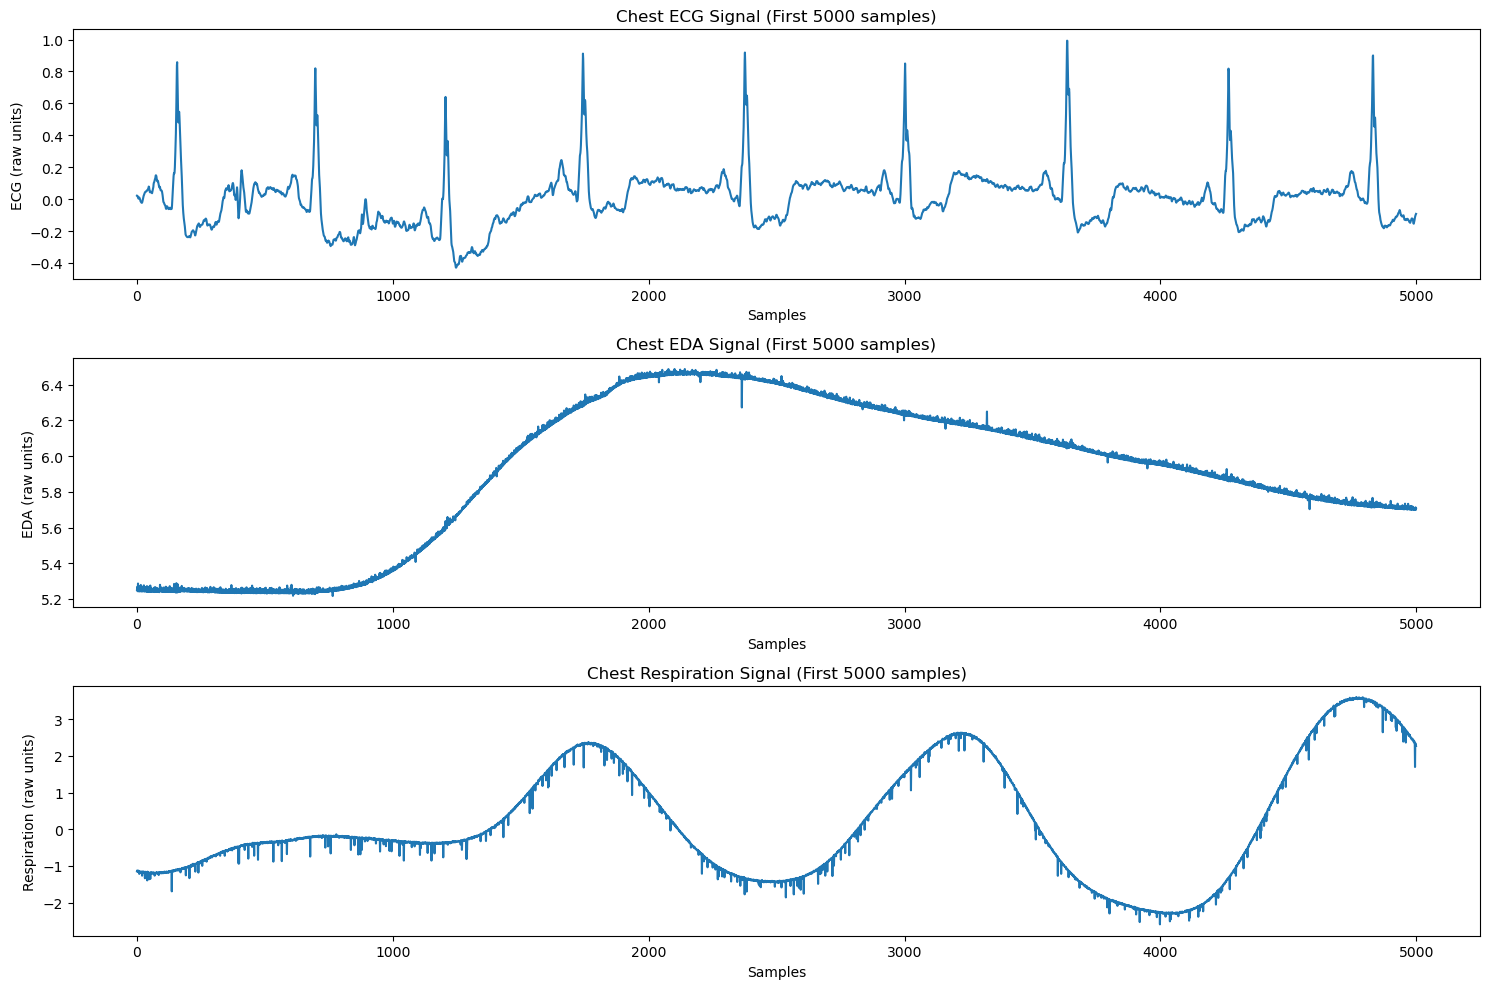

In [9]:
import matplotlib.pyplot as plt

# Let's plot a small sample (for example, first 5000 samples) for easy viewing
num_samples = 5000

# Extract ECG, EDA, Respiration signals
ecg_signal = data['signal']['chest']['ECG'][:num_samples, 0]
eda_signal = data['signal']['chest']['EDA'][:num_samples, 0]
resp_signal = data['signal']['chest']['Resp'][:num_samples, 0]

# Create a figure
plt.figure(figsize=(15, 10))

# Plot ECG
plt.subplot(3, 1, 1)
plt.plot(ecg_signal)
plt.title('Chest ECG Signal (First 5000 samples)')
plt.xlabel('Samples')
plt.ylabel('ECG (raw units)')

# Plot EDA
plt.subplot(3, 1, 2)
plt.plot(eda_signal)
plt.title('Chest EDA Signal (First 5000 samples)')
plt.xlabel('Samples')
plt.ylabel('EDA (raw units)')

# Plot Respiration
plt.subplot(3, 1, 3)
plt.plot(resp_signal)
plt.title('Chest Respiration Signal (First 5000 samples)')
plt.xlabel('Samples')
plt.ylabel('Respiration (raw units)')

# Adjust layout
plt.tight_layout()
plt.show()


# Feature Extraction from Chest Signals

In [12]:
import numpy as np

def sliding_window(signal, window_size, step_size):
    """
    Splits signal into overlapping windows.
    
    Args:
    - signal: np.array of shape (n_samples,)
    - window_size: size of window (in samples)
    - step_size: how much to slide (in samples)

    Returns:
    - windows: list of np.array
    """
    windows = []
    for start in range(0, len(signal) - window_size + 1, step_size):
        end = start + window_size
        windows.append(signal[start:end])
    return np.array(windows)


#Extract ECG Features (Heart Rate and HRV)

In [15]:
from scipy.signal import find_peaks

def extract_ecg_features(ecg_signal, sampling_rate=700):
    """
    Extract HR and HRV features from ECG signal.
    
    Args:
    - ecg_signal: np.array, windowed ECG data
    - sampling_rate: Hz

    Returns:
    - features: dict
    """
    features = {}
    
    # Find R-peaks in ECG
    peaks, _ = find_peaks(ecg_signal.flatten(), distance=sampling_rate/2.5)  # ~ Minimum 0.4s between peaks (~150 BPM max)
    
    # Calculate RR intervals (in seconds)
    rr_intervals = np.diff(peaks) / sampling_rate
    
    if len(rr_intervals) > 1:
        features['heart_rate'] = 60.0 / np.mean(rr_intervals)  # HR in bpm
        features['sdnn'] = np.std(rr_intervals)  # Standard deviation of NN intervals
        features['rmssd'] = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # Root mean square of successive differences
    else:
        features['heart_rate'] = np.nan
        features['sdnn'] = np.nan
        features['rmssd'] = np.nan

    return features


# Extract EDA Features

In [18]:
def extract_eda_features(eda_signal, sampling_rate=700):
    """
    Extract SCL and SCR features from EDA signal.
    
    Args:
    - eda_signal: np.array, windowed EDA data
    - sampling_rate: Hz

    Returns:
    - features: dict
    """
    features = {}
    
    # Skin Conductance Level (SCL)
    features['scl_mean'] = np.mean(eda_signal)
    features['scl_std'] = np.std(eda_signal)
    
    # Number of peaks (Skin Conductance Responses, SCR)
    peaks, _ = find_peaks(eda_signal.flatten(), height=np.mean(eda_signal) + np.std(eda_signal))
    features['num_scr'] = len(peaks)

    return features


#Extract Respiration Features

In [21]:
def extract_respiration_features(resp_signal, sampling_rate=700):
    """
    Extract respiration features.
    
    Args:
    - resp_signal: np.array, windowed respiration data
    - sampling_rate: Hz

    Returns:
    - features: dict
    """
    features = {}
    
    # Basic breathing rate estimation: count zero crossings
    zero_crossings = np.where(np.diff(np.sign(resp_signal)))[0]
    breathing_cycles = len(zero_crossings) / 2  # A full breath = 2 zero crossings
    
    duration_seconds = len(resp_signal) / sampling_rate
    breathing_rate = breathing_cycles / (duration_seconds / 60)  # breaths per minute

    features['breathing_rate'] = breathing_rate

    return features


# for the first 60 seconds (~42000 samples at 700 Hz):

In [24]:
# Parameters
sampling_rate = 700  # Hz
window_duration_seconds = 30
window_size = window_duration_seconds * sampling_rate
step_size = int(0.5 * window_size)  # 50% overlap

# Prepare signals
ecg = data['signal']['chest']['ECG'].flatten()
eda = data['signal']['chest']['EDA'].flatten()
resp = data['signal']['chest']['Resp'].flatten()

# Create windows
ecg_windows = sliding_window(ecg, window_size, step_size)
eda_windows = sliding_window(eda, window_size, step_size)
resp_windows = sliding_window(resp, window_size, step_size)

# Extract features for each window
features_list = []

for i in range(len(ecg_windows)):
    features = {}
    
    # ECG features
    features.update(extract_ecg_features(ecg_windows[i], sampling_rate))
    
    # EDA features
    features.update(extract_eda_features(eda_windows[i], sampling_rate))
    
    # Respiration features
    features.update(extract_respiration_features(resp_windows[i], sampling_rate))
    
    features_list.append(features)

import pandas as pd

# Create a DataFrame
features_df = pd.DataFrame(features_list)

# Show first few rows
print(features_df.head())


   heart_rate      sdnn     rmssd  scl_mean   scl_std  num_scr  breathing_rate
0  115.390177  0.138834  0.121199  5.552593  0.325917     1087           134.0
1  110.711718  0.143490  0.116878  5.457039  0.199054     1431           138.0
2   95.834547  0.143216  0.113696  5.475536  0.182887     1394            98.0
3   92.497726  0.150921  0.183260  5.331628  0.109484     1372            91.0
4   91.110683  0.158211  0.188219  5.421216  0.315461      855           100.0


# PHASE 3: Label Mapping and Model Training

In [27]:
labels = data['label']  # Shape (4255300,)
def window_labels(labels, window_size, step_size):
    """
    Splits the labels into windows and assigns the majority label to each window.
    
    Args:
    - labels: np.array, sequence of labels
    - window_size: samples per window
    - step_size: step between windows (overlap allowed)

    Returns:
    - List of majority labels per window
    """
    windowed_labels = []
    for start in range(0, len(labels) - window_size + 1, step_size):
        end = start + window_size
        window = labels[start:end]
        
        # Ignore windows with mostly label 0
        if np.sum(window == 0) / len(window) > 0.3:  
            windowed_labels.append(-1)  # Invalid
        else:
            majority_label = np.bincount(window[window > 0]).argmax()
            windowed_labels.append(majority_label)
    return np.array(windowed_labels)


In [29]:
# Apply label windowing
windowed_labels = window_labels(data['label'], window_size, step_size)

# Remove invalid windows (-1)
valid_indices = windowed_labels != -1

X = features_df[valid_indices]
y = windowed_labels[valid_indices]

# Check
print(X.shape, y.shape)


(198, 7) (198,)


In [31]:
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [39]:
pip install xgboost lightgbm


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 3.4 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           1       0.42      0.93      0.58        15
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         5
           4       0.71      0.50      0.59        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.47        40
   macro avg       0.19      0.24      0.20        40
weighted avg       0.34      0.47      0.37        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


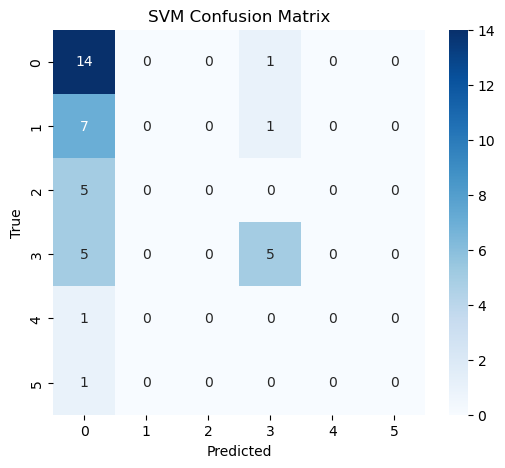


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


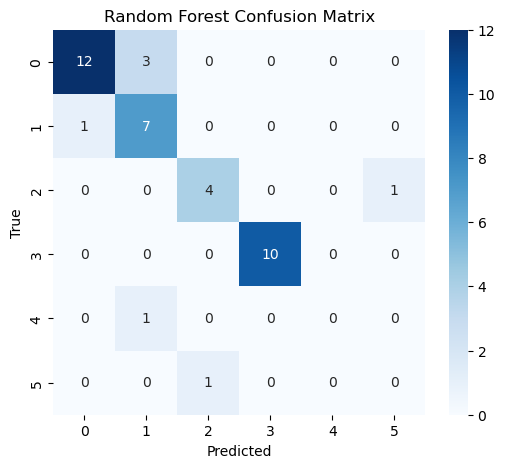


Training XGBoost...


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [18:56:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


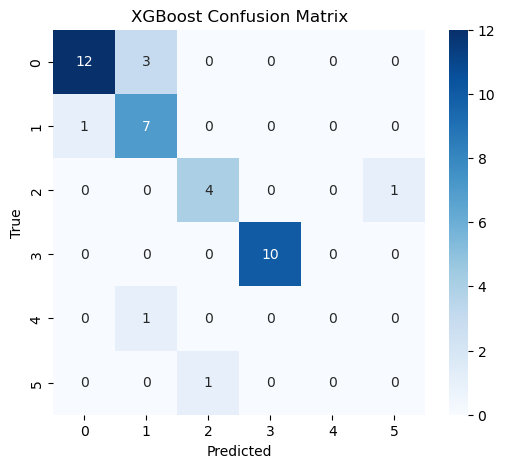


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 371
[LightGBM] [Info] Number of data points in the train set: 158, number of used features: 7
[LightGBM] [Info] Start training from score -0.951721
[LightGBM] [Info] Start training from score -1.566087
[LightGBM] [Info] Start training from score -2.118156
[LightGBM] [Info] Start training from score -1.373716
[LightGBM] [Info] Start training from score -4.369448
[LightGBM] [Info] Start training from score -3.963983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


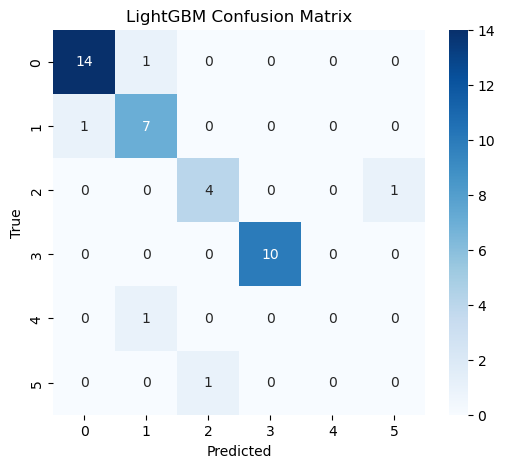

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# -------------------------------
# 1. Prepare Data
# -------------------------------

# Assume we already have features_df and windowed_labels from previous steps
# features_df = your extracted features DataFrame
# windowed_labels = your mapped labels array from sliding windowing

# Filter valid windows
valid_indices = windowed_labels != -1
X = features_df[valid_indices]
y = windowed_labels[valid_indices]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 2. Label Mapping for XGBoost/LightGBM
# -------------------------------

# Create label mapping
label_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5}
map_original_to_mapped = lambda labels: np.array([label_mapping[label] for label in labels])
map_mapped_to_original = lambda labels: np.array([list(label_mapping.keys())[list(label_mapping.values()).index(label)] for label in labels])

# Apply label mapping
y_train_mapped = map_original_to_mapped(y_train)
y_test_mapped = map_original_to_mapped(y_test)

# -------------------------------
# 3. Define Models
# -------------------------------

models = {
    "SVM": SVC(kernel='rbf', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# -------------------------------
# 4. Training and Evaluation
# -------------------------------

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name in ["XGBoost", "LightGBM"]:
        model.fit(X_train, y_train_mapped)
        preds_mapped = model.predict(X_test)
        preds = map_mapped_to_original(preds_mapped)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


# Plot Feature Importance for XGBoost

In [41]:
def plot_xgboost_feature_importance(model, feature_names):
    """
    Plots feature importance for XGBoost model.
    
    Args:
    - model: trained XGBClassifier
    - feature_names: list of feature names
    """
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance Score")
    plt.title("XGBoost Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()


In [43]:
def plot_lightgbm_feature_importance(model, feature_names):
    """
    Plots feature importance for LightGBM model.
    
    Args:
    - model: trained LGBMClassifier
    - feature_names: list of feature names
    """
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 8))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx])
    plt.xlabel("Feature Importance Score")
    plt.title("LightGBM Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()


In [45]:
plt.savefig('xgboost_feature_importance.png', dpi=300)


<Figure size 640x480 with 0 Axes>

In [47]:
pip install joblib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [49]:
import joblib

# Example: Save your best model (say XGBoost)
best_model = models["XGBoost"]

# Save model
joblib.dump(best_model, "xgboost_stress_model.pkl")

print("Model saved successfully as xgboost_stress_model.pkl!")


Model saved successfully as xgboost_stress_model.pkl!


In [51]:
# Load the model
loaded_model = joblib.load("xgboost_stress_model.pkl")

print("Model loaded successfully!")


Model loaded successfully!


In [53]:
# Predict on new test data
preds_mapped = loaded_model.predict(X_test)

# Since it was XGBoost, remember: map back mapped labels to original labels
preds = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped])

# Evaluate
from sklearn.metrics import classification_report

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
import joblib

# Save
joblib.dump(models["XGBoost"], "xgboost_stress_model.pkl")

# Load
loaded_model = joblib.load("xgboost_stress_model.pkl")

# Predict
preds_mapped = loaded_model.predict(X_test)
preds = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped])

# Evaluate
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
import joblib

# Prepare package
package_to_save = {
    'model': models["XGBoost"],             # Save trained model
    'feature_names': list(X_train.columns),  # Save feature list
    'label_mapping': label_mapping           # Save label mapping
}

# Save
joblib.dump(package_to_save, "stress_detection_package.pkl")

print("Full model package saved successfully as stress_detection_package.pkl!")


Full model package saved successfully as stress_detection_package.pkl!


In [59]:
# Load
loaded_package = joblib.load("stress_detection_package.pkl")

# Extract components
loaded_model = loaded_package['model']
loaded_feature_names = loaded_package['feature_names']
loaded_label_mapping = loaded_package['label_mapping']

print("Package loaded successfully!")
print(f"Loaded feature names: {loaded_feature_names}")
print(f"Loaded label mapping: {loaded_label_mapping}")


Package loaded successfully!
Loaded feature names: ['heart_rate', 'sdnn', 'rmssd', 'scl_mean', 'scl_std', 'num_scr', 'breathing_rate']
Loaded label mapping: {1: 0, 2: 1, 3: 2, 4: 3, 6: 4, 7: 5}


In [61]:
# Predict using loaded model
preds_mapped = loaded_model.predict(X_test)

# Map back predicted labels to original
preds = np.array([list(loaded_label_mapping.keys())[list(loaded_label_mapping.values()).index(p)] for p in preds_mapped])

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Simulation Flow

In [63]:
# Simulate new incoming ECG, EDA, Resp signals (first 30 seconds from S2)
sampling_rate = 700  # Hz
window_duration_seconds = 30
window_size = sampling_rate * window_duration_seconds

# New simulated signal
new_ecg = data['signal']['chest']['ECG'][:window_size, 0]
new_eda = data['signal']['chest']['EDA'][:window_size, 0]
new_resp = data['signal']['chest']['Resp'][:window_size, 0]

In [65]:
# Feature extraction functions
def extract_features_from_signals(ecg, eda, resp, sampling_rate=700):
    features = {}
    
    # ECG
    features.update(extract_ecg_features(ecg, sampling_rate))
    
    # EDA
    features.update(extract_eda_features(eda, sampling_rate))
    
    # Respiration
    features.update(extract_respiration_features(resp, sampling_rate))
    
    return features


In [68]:
# Extract features from the new signal
incoming_features = extract_features_from_signals(new_ecg, new_eda, new_resp)


In [70]:
import joblib

# Load full package
loaded_package = joblib.load("stress_detection_package.pkl")

loaded_model = loaded_package['model']
loaded_feature_names = loaded_package['feature_names']
loaded_label_mapping = loaded_package['label_mapping']


In [72]:
# Create a DataFrame for new data
incoming_df = pd.DataFrame([incoming_features])

# Reorder columns to match training time exactly
incoming_df = incoming_df[loaded_feature_names]

# If missing features, fill them with zeros (safety)
incoming_df = incoming_df.fillna(0)


In [74]:
# Predict
preds_mapped = loaded_model.predict(incoming_df)

# Map back to original labels
preds = np.array([list(loaded_label_mapping.keys())[list(loaded_label_mapping.values()).index(p)] for p in preds_mapped])

# Output
print(f"Predicted Stress Level Class: {preds[0]}")


Predicted Stress Level Class: 1


In [76]:
# 1. Simulate New Data
new_ecg = data['signal']['chest']['ECG'][:window_size, 0]
new_eda = data['signal']['chest']['EDA'][:window_size, 0]
new_resp = data['signal']['chest']['Resp'][:window_size, 0]

# 2. Feature Extraction
incoming_features = extract_features_from_signals(new_ecg, new_eda, new_resp)

# 3. Load Model Package
loaded_package = joblib.load("stress_detection_package.pkl")
loaded_model = loaded_package['model']
loaded_feature_names = loaded_package['feature_names']
loaded_label_mapping = loaded_package['label_mapping']

# 4. Prepare Incoming Features
incoming_df = pd.DataFrame([incoming_features])
incoming_df = incoming_df[loaded_feature_names]
incoming_df = incoming_df.fillna(0)

# 5. Predict
preds_mapped = loaded_model.predict(incoming_df)
preds = np.array([list(loaded_label_mapping.keys())[list(loaded_label_mapping.values()).index(p)] for p in preds_mapped])

print(f"Predicted Stress Level Class: {preds[0]}")


Predicted Stress Level Class: 1


In [78]:
##################

In [82]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Prepare param grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 300, 500]
}

# Correct GridSearch setup
grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    param_grid=param_grid,
    cv=2,           # smaller cv
    n_jobs=1,       # use only 1 CPU core to avoid memory crash
    verbose=2
)

# Fit
grid.fit(X_train, y_train_mapped)

# Best model
print("Best parameters:", grid.best_params_)
best_xgb_model = grid.best_estimator_


Fitting 2 folds for each of 27 candidates, totalling 54 fits


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.5s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.5s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.9s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.6s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   0.5s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=500; total time=   0.9s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=500; total time=   0.8s
[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   0.5s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=300; total time=   0.4s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time=   0.7s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ..learning_rate=0.01, max_depth=7, n_estimators=500; total time=   0.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.3s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=300; total time=   0.3s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.6s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=   0.3s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=300; total time=   0.3s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=   0.6s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=   0.5s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=   0.1s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=   0.3s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=500; total time=   0.4s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=500; total time=   0.4s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=500; total time=   0.4s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=500; total time=   0.4s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=500; total time=   0.4s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=500; total time=   0.4s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=   0.0s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=300; total time=   0.2s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=500; total time=   0.4s


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=500; total time=   0.4s
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:08:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [84]:
mask = ~np.isin(y_train_mapped, [4, 5])  # Assuming 4=label6, 5=label7 after mapping
X_train = X_train[mask]
y_train_mapped = y_train_mapped[mask]


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
              precision    recall  f1-score   support

           1       0.92      0.80      0.86        15
           2       0.64      0.88      0.74         8
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.82        40
   macro avg       0.56      0.58      0.57        40
weighted avg       0.82      0.82      0.82        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


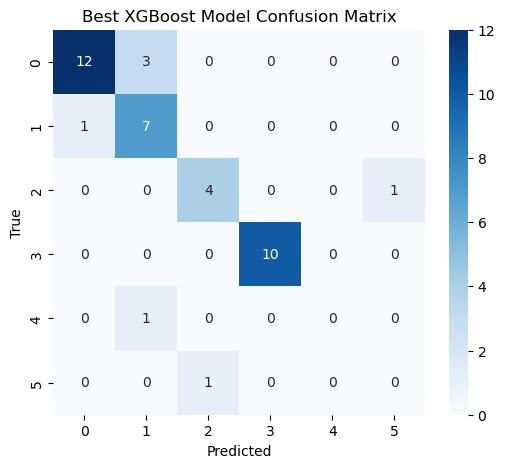

In [86]:
# Step 1: Best hyperparameters found
print("Best parameters:", grid.best_params_)

# Step 2: Best XGBoost model
best_xgb_model = grid.best_estimator_

# Step 3: Predict on Test Set
# Remember: X_test is original test set (features aligned), and labels are y_test, y_test_mapped
preds_mapped = best_xgb_model.predict(X_test)

# Map predictions back to original labels
preds = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped])

# Step 4: Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds))

import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Best XGBoost Model Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Step 1 — Build the DNN Feature Extractor

In [115]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical

# Input size and number of classes
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train_mapped))

# Define model
inputs = Input(shape=(input_dim,))

# First hidden layer
x = Dense(256, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second hidden layer
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Third hidden layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Fourth hidden layer
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Fifth hidden layer
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
features = x
outputs = Dense(num_classes, activation='softmax')(features)

# Create the model
classifier_model = Model(inputs=inputs, outputs=outputs)

# Compile
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
classifier_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,860 (186.95 KB)

 Trainable params: 46,868 (183.08 KB)

 Non-trainable params: 992 (3.88 KB)

In [125]:
classifier_model.fit(X_train, y_train_mapped, 
                     epochs=30, 
                     batch_size=16, 
                     validation_split=0.1, 
                     verbose=1)



Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5552 - loss: 0.8952 - val_accuracy: 0.4375 - val_loss: 0.9478
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6582 - loss: 0.7966 - val_accuracy: 0.6875 - val_loss: 0.8208
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6379 - loss: 0.7844 - val_accuracy: 0.6875 - val_loss: 0.6947
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7112 - loss: 0.6895 - val_accuracy: 0.6250 - val_loss: 0.7925
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6960 - loss: 0.7668 - val_accuracy: 0.7500 - val_loss: 0.7144
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6653 - loss: 0.7698 - val_accuracy: 0.8125 - val_loss: 0.5305
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7216 - loss: 0.7135 - val_accuracy: 0.9375 - val_loss: 0.4872
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5874 - loss: 0.9398 - val_accuracy: 0.9375 - val_loss: 0.4890


In [131]:
# Create feature extractor from the DNN
feature_extractor = Model(inputs=classifier_model.input, outputs=features)

# Deep feature extraction
X_train_deep = feature_extractor.predict(X_train)
X_test_deep = feature_extractor.predict(X_test)



5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:19:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: 

              precision    recall  f1-score   support

           1       0.85      0.73      0.79        15
           2       0.55      0.75      0.63         8
           3       0.57      0.80      0.67         5
           4       1.00      0.90      0.95        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.75        40
   macro avg       0.49      0.53      0.51        40
weighted avg       0.75      0.75      0.74        40



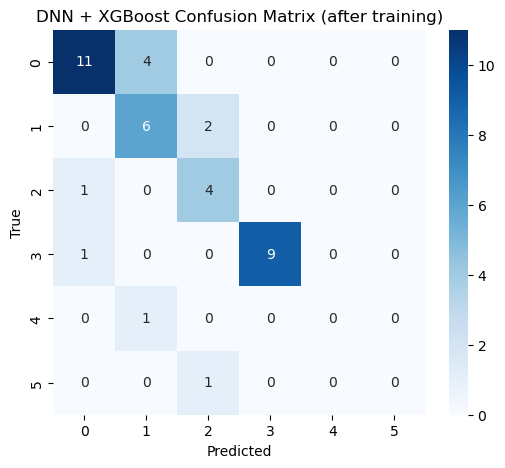

In [133]:
# Train XGBoost on extracted features
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_deep, y_train_mapped)

# Predict
preds_mapped = xgb.predict(X_test_deep)

# Map back to original labels
preds = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped])

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, preds))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("DNN + XGBoost Confusion Matrix (after training)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Step 1 — Stack (Concatenate) Features

In [136]:
import numpy as np

# Concatenate along feature axis (axis=1)
X_train_hybrid = np.concatenate([X_train, X_train_deep], axis=1)
X_test_hybrid = np.concatenate([X_test, X_test_deep], axis=1)

print("Hybrid training feature shape:", X_train_hybrid.shape)
print("Hybrid test feature shape:", X_test_hybrid.shape)


Hybrid training feature shape: (153, 23)
Hybrid test feature shape: (40, 23)


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: 

              precision    recall  f1-score   support

           1       1.00      0.87      0.93        15
           2       0.73      1.00      0.84         8
           3       0.80      0.80      0.80         5
           4       0.91      1.00      0.95        10
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1

    accuracy                           0.88        40
   macro avg       0.57      0.61      0.59        40
weighted avg       0.85      0.88      0.85        40



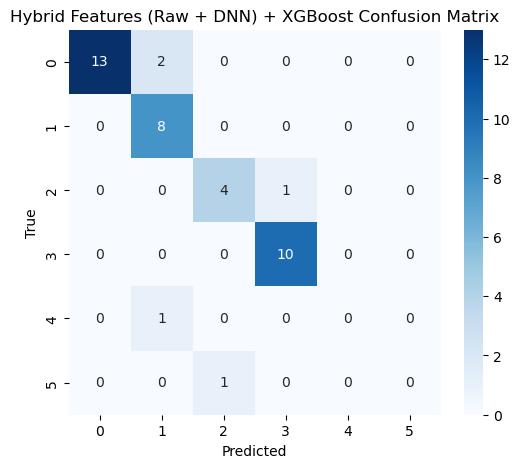

In [138]:
from xgboost import XGBClassifier

# Train XGBoost on hybrid feature space
xgb_hybrid = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

xgb_hybrid.fit(X_train_hybrid, y_train_mapped)

# Predict
preds_mapped_hybrid = xgb_hybrid.predict(X_test_hybrid)
preds_hybrid = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped_hybrid])

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, preds_hybrid))

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_hybrid)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid Features (Raw + DNN) + XGBoost Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [140]:
# Remove classes 6 and 7 (their mapped values were 4 and 5)

# For training set
mask_train = y_train_mapped < 4  # Keep only classes 0,1,2,3 (original labels 1-4)
X_train_hybrid_clean = X_train_hybrid[mask_train]
y_train_mapped_clean = y_train_mapped[mask_train]

# For test set
mask_test = y_test_mapped < 4
X_test_hybrid_clean = X_test_hybrid[mask_test]
y_test_mapped_clean = y_test_mapped[mask_test]
y_test_clean = y_test[mask_test]  # original labels 1–4 for evaluation


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:22:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           1       1.00      0.87      0.93        15
           2       0.80      1.00      0.89         8
           3       1.00      0.80      0.89         5
           4       0.91      1.00      0.95        10

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.91        38
weighted avg       0.93      0.92      0.92        38



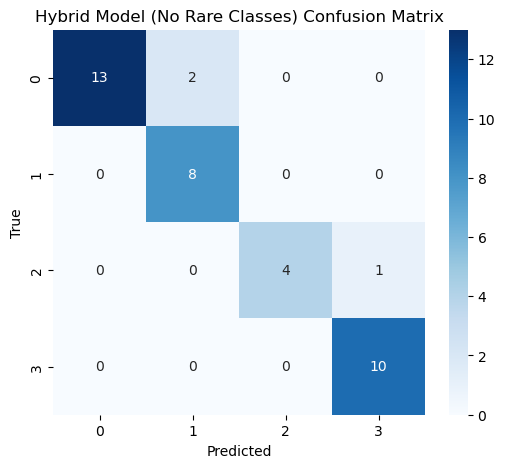

In [142]:
xgb_hybrid_clean = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_hybrid_clean.fit(X_train_hybrid_clean, y_train_mapped_clean)

# Predict
preds_mapped_clean = xgb_hybrid_clean.predict(X_test_hybrid_clean)
preds_clean = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped_clean])

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_clean, preds_clean))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_clean, preds_clean)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Hybrid Model (No Rare Classes) Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [144]:
# Full VotingClassifier Code 


C:\Users\14377\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [19:23:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 23
[LightGBM] [Info] Start training from score -0.919564
[LightGBM] [Info] Start training from score -1.533930
[LightGBM] [Info] Start training from score -2.085999
[LightGBM] [Info] Start training from score -1.341558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

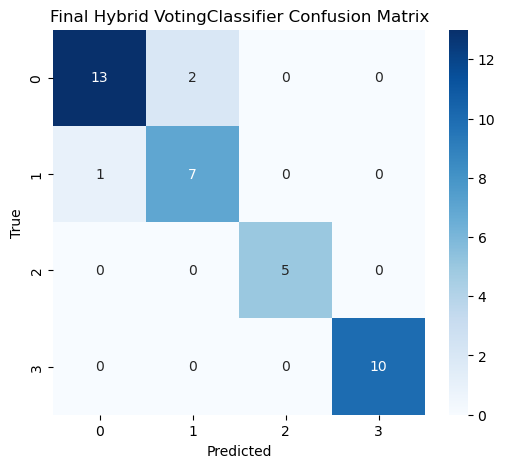

In [146]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Define individual models (you can adjust parameters if you want)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
lgbm = LGBMClassifier(random_state=42)

# Create the ensemble Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb),
        ('rf', rf),
        ('lgbm', lgbm)
    ],
    voting='soft',  # 'soft' gives better probabilities blending
    n_jobs=1
)

# Train on hybrid features
voting_model.fit(X_train_hybrid_clean, y_train_mapped_clean)

# Predict
preds_mapped_voting = voting_model.predict(X_test_hybrid_clean)
preds_voting = np.array([list(label_mapping.keys())[list(label_mapping.values()).index(p)] for p in preds_mapped_voting])

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_clean, preds_voting))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_clean, preds_voting)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Final Hybrid VotingClassifier Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
